<a href="https://colab.research.google.com/github/thdefn/jango/blob/master/nongen_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
import pandas as pd

from tensorflow import keras

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization 
from tensorflow.keras.utils import to_categorical

In [17]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

import seaborn as sns
import os
import glob
import plotly.graph_objects as go
import cv2
from PIL import Image
from PIL import ImageFile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tqdm import tqdm

In [18]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [19]:
cd /content/gdrive/My Drive/data/.kaggle

/content/gdrive/My Drive/data/.kaggle


In [20]:
X_valid = np.load('./X_valid_128.npy',allow_pickle=True)
y_valid = np.load('./y_valid_128.npy',allow_pickle=True)
X_train = np.load('./X_train_128.npy',allow_pickle=True)
y_train = np.load('./y_train_128.npy',allow_pickle=True)

In [21]:
X_train = X_train/255
X_valid = X_valid/255

le = LabelEncoder().fit(['Type 1', 'Type 2', 'Type 3'])
y_train = le.transform(y_train)
y_valid = le.transform(y_valid)

y_train_onehot = to_categorical(y_train, num_classes=3)
y_valid_onehot = to_categorical(y_valid, num_classes=3)


In [22]:
reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

checkpoint_ag = ModelCheckpoint('v1_ag', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [23]:
BATCH_SIZE = 16
TRAIN_STEPS = len(X_train)//BATCH_SIZE
VAL_STEPS = len(X_valid)//BATCH_SIZE

In [24]:
'''train_gen = ImageDataGenerator(
                     rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.1,
                     vertical_flip=True,
                     horizontal_flip=True,
                     fill_mode='nearest').flow(X_train, y_train_onehot, batch_size = BATCH_SIZE)'''
valid_gen = ImageDataGenerator().flow(X_valid, y_valid_onehot, batch_size = BATCH_SIZE)


train_gen = ImageDataGenerator().flow(X_train, y_train_onehot, batch_size = BATCH_SIZE)

In [25]:
cnn = Sequential([
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal', input_shape=(128,128,3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(32, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(64, kernel_initializer='random_normal'),
    Activation('relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
    
])

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 activation_4 (Activation)   (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 activation_5 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                  



### 모델 세이빙

In [26]:
cnn.compile(
    'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [27]:
general = cnn.fit(train_gen, validation_data= valid_gen, epochs= 30, verbose=1,  steps_per_epoch = TRAIN_STEPS, callbacks= [reduceLR, early_stopping, checkpoint_ag]) #피팅
cnn.save('my_nongenmodel.h5') #모델 세이브

Epoch 1/30
410/410 [==============================] - ETA: 0s - loss: 1.0157 - accuracy: 0.5187
Epoch 1: val_accuracy improved from -inf to 0.52952, saving model to v1_ag


410/410 [==============================] - 242s 588ms/step - loss: 1.0157 - accuracy: 0.5187 - val_loss: 0.9841 - val_accuracy: 0.5295 - lr: 0.0010
Epoch 2/30
410/410 [==============================] - ETA: 0s - loss: 0.9871 - accuracy: 0.5304
Epoch 2: val_accuracy did not improve from 0.52952
410/410 [==============================] - 232s 566ms/step - loss: 0.9871 - accuracy: 0.5304 - val_loss: 0.9726 - val_accuracy: 0.5289 - lr: 0.0010
Epoch 3/30
410/410 [==============================] - ETA: 0s - loss: 0.9736 - accuracy: 0.5278
Epoch 3: val_accuracy improved from 0.52952 to 0.54656, saving model to v1_ag


410/410 [==============================] - 231s 564ms/step - loss: 0.9736 - accuracy: 0.5278 - val_loss: 0.9457 - val_accuracy: 0.5466 - lr: 0.0010
Epoch 4/30
410/410 [==============================] - ETA: 0s - loss: 0.9467 - accuracy: 0.5437
Epoch 4: val_accuracy improved from 0.54656 to 0.55204, saving model to v1_ag


410/410 [==============================] - 231s 564ms/step - loss: 0.9467 - accuracy: 0.5437 - val_loss: 0.9352 - val_accuracy: 0.5520 - lr: 0.0010
Epoch 5/30
410/410 [==============================] - ETA: 0s - loss: 0.9204 - accuracy: 0.5471
Epoch 5: val_accuracy improved from 0.55204 to 0.55447, saving model to v1_ag


410/410 [==============================] - 231s 565ms/step - loss: 0.9204 - accuracy: 0.5471 - val_loss: 0.9137 - val_accuracy: 0.5545 - lr: 0.0010
Epoch 6/30
410/410 [==============================] - ETA: 0s - loss: 0.8921 - accuracy: 0.5611
Epoch 6: val_accuracy improved from 0.55447 to 0.56786, saving model to v1_ag


410/410 [==============================] - 230s 561ms/step - loss: 0.8921 - accuracy: 0.5611 - val_loss: 0.9077 - val_accuracy: 0.5679 - lr: 0.0010
Epoch 7/30
410/410 [==============================] - ETA: 0s - loss: 0.8608 - accuracy: 0.5803
Epoch 7: val_accuracy improved from 0.56786 to 0.57638, saving model to v1_ag


410/410 [==============================] - 235s 574ms/step - loss: 0.8608 - accuracy: 0.5803 - val_loss: 0.8779 - val_accuracy: 0.5764 - lr: 0.0010
Epoch 8/30
410/410 [==============================] - ETA: 0s - loss: 0.8264 - accuracy: 0.5984
Epoch 8: val_accuracy improved from 0.57638 to 0.58430, saving model to v1_ag


410/410 [==============================] - 230s 561ms/step - loss: 0.8264 - accuracy: 0.5984 - val_loss: 0.8693 - val_accuracy: 0.5843 - lr: 0.0010
Epoch 9/30
410/410 [==============================] - ETA: 0s - loss: 0.7825 - accuracy: 0.6182
Epoch 9: val_accuracy improved from 0.58430 to 0.58977, saving model to v1_ag


410/410 [==============================] - 237s 577ms/step - loss: 0.7825 - accuracy: 0.6182 - val_loss: 0.8758 - val_accuracy: 0.5898 - lr: 0.0010
Epoch 10/30
410/410 [==============================] - ETA: 0s - loss: 0.7423 - accuracy: 0.6400
Epoch 10: val_accuracy improved from 0.58977 to 0.60499, saving model to v1_ag


410/410 [==============================] - 230s 561ms/step - loss: 0.7423 - accuracy: 0.6400 - val_loss: 0.8508 - val_accuracy: 0.6050 - lr: 0.0010
Epoch 11/30
410/410 [==============================] - ETA: 0s - loss: 0.6856 - accuracy: 0.6774
Epoch 11: val_accuracy improved from 0.60499 to 0.61960, saving model to v1_ag


410/410 [==============================] - 233s 569ms/step - loss: 0.6856 - accuracy: 0.6774 - val_loss: 0.8665 - val_accuracy: 0.6196 - lr: 0.0010
Epoch 12/30
410/410 [==============================] - ETA: 0s - loss: 0.6393 - accuracy: 0.7027
Epoch 12: val_accuracy did not improve from 0.61960
410/410 [==============================] - 229s 558ms/step - loss: 0.6393 - accuracy: 0.7027 - val_loss: 0.9198 - val_accuracy: 0.6026 - lr: 0.0010
Epoch 13/30
410/410 [==============================] - ETA: 0s - loss: 0.5965 - accuracy: 0.7171
Epoch 13: val_accuracy did not improve from 0.61960
410/410 [==============================] - 228s 556ms/step - loss: 0.5965 - accuracy: 0.7171 - val_loss: 0.9447 - val_accuracy: 0.6123 - lr: 0.0010
Epoch 14/30
410/410 [==============================] - ETA: 0s - loss: 0.5421 - accuracy: 0.7506
Epoch 14: val_accuracy did not improve from 0.61960
410/410 [==============================] - 229s 559ms/step - loss: 0.5421 - accuracy: 0.7506 - val_loss: 1.02

410/410 [==============================] - 225s 549ms/step - loss: 0.3293 - accuracy: 0.8443 - val_loss: 1.4539 - val_accuracy: 0.6293 - lr: 0.0010
Epoch 22/30
410/410 [==============================] - ETA: 0s - loss: 0.3233 - accuracy: 0.8459
Epoch 22: val_accuracy did not improve from 0.62934
410/410 [==============================] - 227s 554ms/step - loss: 0.3233 - accuracy: 0.8459 - val_loss: 1.3401 - val_accuracy: 0.6220 - lr: 0.0010
Epoch 23/30
410/410 [==============================] - ETA: 0s - loss: 0.3025 - accuracy: 0.8549
Epoch 23: val_accuracy did not improve from 0.62934
410/410 [==============================] - 223s 545ms/step - loss: 0.3025 - accuracy: 0.8549 - val_loss: 1.4759 - val_accuracy: 0.6159 - lr: 0.0010
Epoch 24/30
410/410 [==============================] - ETA: 0s - loss: 0.3083 - accuracy: 0.8526
Epoch 24: val_accuracy improved from 0.62934 to 0.63299, saving model to v1_ag


410/410 [==============================] - 224s 547ms/step - loss: 0.3083 - accuracy: 0.8526 - val_loss: 1.5153 - val_accuracy: 0.6330 - lr: 0.0010
Epoch 25/30
410/410 [==============================] - ETA: 0s - loss: 0.2896 - accuracy: 0.8622
Epoch 25: val_accuracy improved from 0.63299 to 0.64273, saving model to v1_ag


410/410 [==============================] - 224s 547ms/step - loss: 0.2896 - accuracy: 0.8622 - val_loss: 1.5797 - val_accuracy: 0.6427 - lr: 0.0010
Epoch 26/30
410/410 [==============================] - ETA: 0s - loss: 0.2596 - accuracy: 0.8758
Epoch 26: val_accuracy did not improve from 0.64273
410/410 [==============================] - 223s 544ms/step - loss: 0.2596 - accuracy: 0.8758 - val_loss: 1.7810 - val_accuracy: 0.6166 - lr: 0.0010
Epoch 27/30
410/410 [==============================] - ETA: 0s - loss: 0.2624 - accuracy: 0.8720
Epoch 27: val_accuracy did not improve from 0.64273
410/410 [==============================] - 223s 544ms/step - loss: 0.2624 - accuracy: 0.8720 - val_loss: 1.5550 - val_accuracy: 0.6287 - lr: 0.0010
Epoch 28/30
410/410 [==============================] - ETA: 0s - loss: 0.2431 - accuracy: 0.8799
Epoch 28: val_accuracy did not improve from 0.64273
410/410 [==============================] - 223s 544ms/step - loss: 0.2431 - accuracy: 0.8799 - val_loss: 1.67

In [ ]:
cnn = keras.models.load_model('my_nongenmodel.h5')
cnn.compile(
    'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [ ]:
general = cnn.fit(train_gen, validation_data= valid_gen, epochs= 30, verbose=1,  steps_per_epoch = TRAIN_STEPS, callbacks= [reduceLR, checkpoint_ag]) #피팅
cnn.save('my_nongenmodel2.h5')

Epoch 1/20
410/410 [==============================] - ETA: 0s - loss: 0.8844 - accuracy: 0.5654
Epoch 1: val_accuracy did not improve from 0.59586
410/410 [==============================] - 26s 63ms/step - loss: 0.8844 - accuracy: 0.5654 - val_loss: 0.8887 - val_accuracy: 0.5636 - lr: 0.0010
Epoch 2/20
410/410 [==============================] - ETA: 0s - loss: 0.8693 - accuracy: 0.5686
Epoch 2: val_accuracy did not improve from 0.59586
410/410 [==============================] - 26s 63ms/step - loss: 0.8693 - accuracy: 0.5686 - val_loss: 0.8667 - val_accuracy: 0.5806 - lr: 0.0010
Epoch 3/20
410/410 [==============================] - ETA: 0s - loss: 0.8773 - accuracy: 0.5611
Epoch 3: val_accuracy did not improve from 0.59586
410/410 [==============================] - 25s 62ms/step - loss: 0.8773 - accuracy: 0.5611 - val_loss: 0.8673 - val_accuracy: 0.5934 - lr: 0.0010
Epoch 4/20
410/410 [==============================] - ETA: 0s - loss: 0.8611 - accuracy: 0.5707
Epoch 4: val_accuracy did

410/410 [==============================] - 27s 66ms/step - loss: 0.8632 - accuracy: 0.5782 - val_loss: 0.8546 - val_accuracy: 0.5971 - lr: 0.0010
Epoch 10/20
410/410 [==============================] - ETA: 0s - loss: 0.8574 - accuracy: 0.5768
Epoch 10: val_accuracy did not improve from 0.59708
410/410 [==============================] - 25s 62ms/step - loss: 0.8574 - accuracy: 0.5768 - val_loss: 0.8808 - val_accuracy: 0.5892 - lr: 0.0010
Epoch 11/20
410/410 [==============================] - ETA: 0s - loss: 0.8585 - accuracy: 0.5771
Epoch 11: val_accuracy did not improve from 0.59708
410/410 [==============================] - 26s 63ms/step - loss: 0.8585 - accuracy: 0.5771 - val_loss: 0.8578 - val_accuracy: 0.5922 - lr: 0.0010
Epoch 12/20
410/410 [==============================] - ETA: 0s - loss: 0.8605 - accuracy: 0.5715
Epoch 12: val_accuracy did not improve from 0.59708
410/410 [==============================] - 25s 62ms/step - loss: 0.8605 - accuracy: 0.5715 - val_loss: 0.8572 - val

410/410 [==============================] - 27s 65ms/step - loss: 0.8517 - accuracy: 0.5794 - val_loss: 0.8436 - val_accuracy: 0.5977 - lr: 0.0010
Epoch 17/20
410/410 [==============================] - ETA: 0s - loss: 0.8542 - accuracy: 0.5808
Epoch 17: val_accuracy improved from 0.59769 to 0.59890, saving model to v1_ag


410/410 [==============================] - 27s 65ms/step - loss: 0.8542 - accuracy: 0.5808 - val_loss: 0.8565 - val_accuracy: 0.5989 - lr: 0.0010
Epoch 18/20
410/410 [==============================] - ETA: 0s - loss: 0.8545 - accuracy: 0.5825
Epoch 18: val_accuracy did not improve from 0.59890
410/410 [==============================] - 26s 62ms/step - loss: 0.8545 - accuracy: 0.5825 - val_loss: 0.8647 - val_accuracy: 0.5813 - lr: 0.0010
Epoch 19/20
410/410 [==============================] - ETA: 0s - loss: 0.8416 - accuracy: 0.5919
Epoch 19: val_accuracy did not improve from 0.59890
410/410 [==============================] - 25s 62ms/step - loss: 0.8416 - accuracy: 0.5919 - val_loss: 0.8646 - val_accuracy: 0.5788 - lr: 0.0010
Epoch 20/20
410/410 [==============================] - ETA: 0s - loss: 0.8556 - accuracy: 0.5756
Epoch 20: val_accuracy did not improve from 0.59890
410/410 [==============================] - 27s 65ms/step - loss: 0.8556 - accuracy: 0.5756 - val_loss: 0.8501 - val

In [ ]:
with open('nongenhistory.pkl', 'rb') as f:
	df = pickle.load(f)

In [ ]:
 for i in range(len(general.history['loss'])):
    df['loss'].append(general.history['loss'][i])
    df['accuracy'].append(general.history['accuracy'][i])
    df['val_loss'].append(general.history['val_loss'][i])
    df['val_accuracy'].append(general.history['val_accuracy'][i])

In [37]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(df['accuracy'], label='acc')
plt.plot(df['val_accuracy'], label='val_acc')
plt.legend(loc='lower right')
plt.title('Accuracy comparison')

plt.subplot(1, 2, 2)
plt.plot(df['loss'], label='loss')
plt.plot(df['val_loss'], label='val_loss')
plt.legend(loc='upper right')
plt.title('Loss comparison')

plt.show()

"plt.figure(figsize=(15, 5))\n\nplt.subplot(1, 2, 1)\nplt.plot(df['accuracy'], label='acc')\nplt.plot(df['val_accuracy'], label='val_acc')\nplt.legend(loc='lower right')\nplt.title('Accuracy comparison')\n\nplt.subplot(1, 2, 2)\nplt.plot(df['loss'], label='loss')\nplt.plot(df['val_loss'], label='val_loss')\nplt.legend(loc='upper right')\nplt.title('Loss comparison')\n\nplt.show()"

In [28]:
import pickle

with open('nongenhistory.pkl', 'wb') as f:
	pickle.dump(general.history, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
general.history

{'loss': [0.9039056301116943,
  0.9025745391845703,
  0.9032078981399536,
  0.8993801474571228,
  0.9003708958625793,
  0.8959671854972839,
  0.9038596153259277,
  0.8989343047142029,
  0.8936007618904114,
  0.9035616517066956,
  0.8958168029785156,
  0.8896105289459229,
  0.8897523283958435,
  0.8923231959342957,
  0.8956129550933838,
  0.8869773745536804,
  0.89104825258255,
  0.8824651837348938,
  0.8879295587539673,
  0.8867347240447998,
  0.8804314732551575,
  0.8861970901489258,
  0.8574673533439636,
  0.8588854670524597,
  0.8574600219726562,
  0.8593003153800964,
  0.8575767874717712,
  0.850236713886261,
  0.8536825180053711,
  0.8512020707130432],
 'accuracy': [0.5475354790687561,
  0.5486037135124207,
  0.5511979460716248,
  0.5432626008987427,
  0.5489088892936707,
  0.5513505339622498,
  0.5548603534698486,
  0.5504348874092102,
  0.5550129413604736,
  0.5479933023452759,
  0.5551655888557434,
  0.5559285879135132,
  0.5540973544120789,
  0.5479933023452759,
  0.5496718883

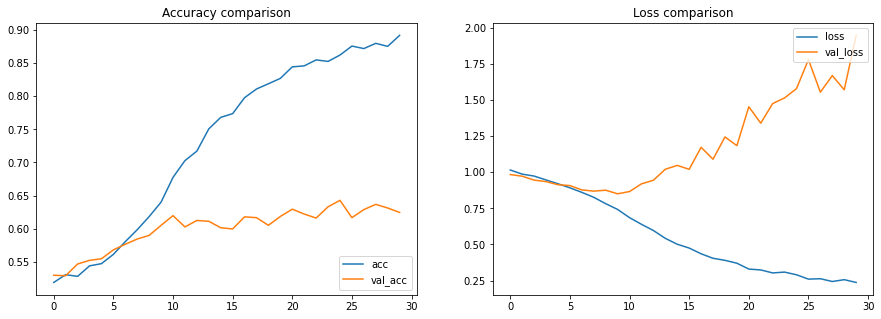

In [29]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(general.history['accuracy'], label='acc')
plt.plot(general.history['val_accuracy'], label='val_acc')
plt.legend(loc='lower right')
plt.title('Accuracy comparison')

plt.subplot(1, 2, 2)
plt.plot(general.history['loss'], label='loss')
plt.plot(general.history['val_loss'], label='val_loss')
plt.legend(loc='upper right')
plt.title('Loss comparison')

plt.show()

In [30]:
X_test = np.load('./X_test_128.npy',allow_pickle=True)
y_test = np.load('./y_test_128.npy',allow_pickle=True)
X_test = X_test/255

In [31]:
y_test = np.array(y_test).astype(np.float32)
cnn.evaluate(X_test, y_test)

16/16 [==============================] - 4s 239ms/step - loss: 2.2692 - accuracy: 0.5820


[2.269235610961914, 0.58203125]

In [35]:
import torch
y_test = torch.Tensor(y_test)
y_test = torch.argmax(y_test, dim=1)

In [36]:
y_pred_enc = cnn.predict(X_test)          # one-hot encoding된 label 예측값
y_pred = [np.argmax(i) for i in y_pred_enc] # label 예측값
matrix = confusion_matrix(y_test, y_pred)
item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

16/16 [==============================] - 4s 273ms/step


,Type 1,Type 2,Type 3
Type 1,24,56,7
Type 2,19,203,43
Type 3,4,85,71
